## Data Processing

In [1]:
token_path = r"Flick8k/Flick8k_text/Flickr8k.token.txt"
train_images_path = r'Flick8k/Flick8k_text/Flickr_8k.trainImages.txt'
test_images_path = r'Flick8k/Flick8k_text/Flickr_8k.testImages.txt'
images_path = r'Flick8k/Flick8k_Dataset/Flicker8k_Dataset'
glove_path = r'glove.6B'

In [2]:
doc = open(token_path,'r').read()
print(doc[:410])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .


In [3]:
descriptions = dict()
for line in doc.split('\n'):
        tokens = line.split()
        if len(line) > 2:
          image_id = tokens[0].split('.')[0]
          image_desc = ' '.join(tokens[1:])
          if image_id not in descriptions:
              descriptions[image_id] = list()
          descriptions[image_id].append(image_desc)

In [4]:
import string
table = str.maketrans('', '', string.punctuation)
for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc = desc_list[i]
        desc = desc.split()
        desc = [word.lower() for word in desc]
        desc = [w.translate(table) for w in desc]
        desc_list[i] =  ' '.join(desc)

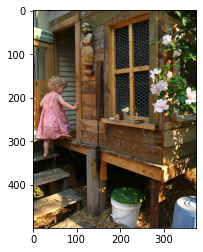

['a child in a pink dress is climbing up a set of stairs in an entry way ',
 'a girl going into a wooden building ',
 'a little girl climbing into a wooden playhouse ',
 'a little girl climbing the stairs to her playhouse ',
 'a little girl in a pink dress going into a wooden cabin ']

In [5]:
import matplotlib.pyplot as plt
pic = '1000268201_693b08cb0e.jpg'
x = plt.imread(images_path + "/" + pic)
plt.imshow(x)
plt.show()
descriptions['1000268201_693b08cb0e']

In [6]:
vocabulary = set()
for key in descriptions.keys():
        [vocabulary.update(d.split()) for d in descriptions[key]]
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8828


In [7]:
lines = list()
for key, desc_list in descriptions.items():
    for desc in desc_list:
        lines.append(key + ' ' + desc)
new_descriptions = '\n'.join(lines)

In [8]:
doc = open(train_images_path,'r').read()
dataset = list()
for line in doc.split('\n'):
    if len(line) > 1:
      identifier = line.split('.')[0]
      dataset.append(identifier)

train = set(dataset)

In [9]:
file1 = open(train_images_path, "r")
train_img = file1.readlines()
for i in range(len(train_img)):
    train_img[i] = str(images_path + "/" + train_img[i][:-1])
    
file2 = open(test_images_path, "r")
test_img = file2.readlines()
for i in range(len(test_img)):
    test_img[i] = str(images_path + "/" + test_img[i][:-1])

In [10]:
train_descriptions = dict()
for line in new_descriptions.split('\n'):
    tokens = line.split()
    image_id, image_desc = tokens[0], tokens[1:]
    if image_id in train:
        if image_id not in train_descriptions:
            train_descriptions[image_id] = list()
        desc = "startseq " + ' '.join(image_desc) + " endseq"
        train_descriptions[image_id].append(desc)

In [11]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)

In [12]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

print('Vocabulary = %d' % (len(vocab)))

Vocabulary = 1659


In [13]:
ixtoword = {}
wordtoix = {}
ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1

In [14]:
all_desc = list()
for key in train_descriptions.keys():
    [all_desc.append(d) for d in train_descriptions[key]]
lines = all_desc
max_length = max(len(d.split()) for d in lines)

print('Description Length: %d' % max_length)

Description Length: 38


## GloVe Embeddings

In [15]:
import os
import numpy as np
embeddings_index = {} 
f = open(os.path.join(glove_path, 'glove.6B.200d.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

In [16]:
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

## Model Building and Training

In [17]:
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout, Bidirectional
from tensorflow.keras.layers import add
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

Using InceptionV3 for encoding images.

In [18]:
model = InceptionV3(weights = 'imagenet')

In [19]:
model_new = Model(model.input, model.layers[-2].output)

In [20]:
from PIL import Image
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [21]:
def encode(image):
    image = preprocess(image) 
    fea_vec = model_new.predict(image) 
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

encoding_train = {}
i = 0
for img in train_img:
    encoding_train[img[len(images_path) + 1:]] = encode(img)
    i += 1
    print("Training image", i, " encoded.\n")
train_features = encoding_train
i = 0
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images_path) + 1:]] = encode(img)
    i += 1
    print("Testing image", i, " encoded.\n")

Training image 1  encoded.

Training image 2  encoded.

Training image 3  encoded.

Training image 4  encoded.

Training image 5  encoded.

Training image 6  encoded.

Training image 7  encoded.

Training image 8  encoded.

Training image 9  encoded.

Training image 10  encoded.

Training image 11  encoded.

Training image 12  encoded.

Training image 13  encoded.

Training image 14  encoded.

Training image 15  encoded.

Training image 16  encoded.

Training image 17  encoded.

Training image 18  encoded.

Training image 19  encoded.

Training image 20  encoded.

Training image 21  encoded.

Training image 22  encoded.

Training image 23  encoded.

Training image 24  encoded.

Training image 25  encoded.

Training image 26  encoded.

Training image 27  encoded.

Training image 28  encoded.

Training image 29  encoded.

Training image 30  encoded.

Training image 31  encoded.

Training image 32  encoded.

Training image 33  encoded.

Training image 34  encoded.

Training image 35  enco

Training image 278  encoded.

Training image 279  encoded.

Training image 280  encoded.

Training image 281  encoded.

Training image 282  encoded.

Training image 283  encoded.

Training image 284  encoded.

Training image 285  encoded.

Training image 286  encoded.

Training image 287  encoded.

Training image 288  encoded.

Training image 289  encoded.

Training image 290  encoded.

Training image 291  encoded.

Training image 292  encoded.

Training image 293  encoded.

Training image 294  encoded.

Training image 295  encoded.

Training image 296  encoded.

Training image 297  encoded.

Training image 298  encoded.

Training image 299  encoded.

Training image 300  encoded.

Training image 301  encoded.

Training image 302  encoded.

Training image 303  encoded.

Training image 304  encoded.

Training image 305  encoded.

Training image 306  encoded.

Training image 307  encoded.

Training image 308  encoded.

Training image 309  encoded.

Training image 310  encoded.

Training i

Training image 552  encoded.

Training image 553  encoded.

Training image 554  encoded.

Training image 555  encoded.

Training image 556  encoded.

Training image 557  encoded.

Training image 558  encoded.

Training image 559  encoded.

Training image 560  encoded.

Training image 561  encoded.

Training image 562  encoded.

Training image 563  encoded.

Training image 564  encoded.

Training image 565  encoded.

Training image 566  encoded.

Training image 567  encoded.

Training image 568  encoded.

Training image 569  encoded.

Training image 570  encoded.

Training image 571  encoded.

Training image 572  encoded.

Training image 573  encoded.

Training image 574  encoded.

Training image 575  encoded.

Training image 576  encoded.

Training image 577  encoded.

Training image 578  encoded.

Training image 579  encoded.

Training image 580  encoded.

Training image 581  encoded.

Training image 582  encoded.

Training image 583  encoded.

Training image 584  encoded.

Training i

Training image 827  encoded.

Training image 828  encoded.

Training image 829  encoded.

Training image 830  encoded.

Training image 831  encoded.

Training image 832  encoded.

Training image 833  encoded.

Training image 834  encoded.

Training image 835  encoded.

Training image 836  encoded.

Training image 837  encoded.

Training image 838  encoded.

Training image 839  encoded.

Training image 840  encoded.

Training image 841  encoded.

Training image 842  encoded.

Training image 843  encoded.

Training image 844  encoded.

Training image 845  encoded.

Training image 846  encoded.

Training image 847  encoded.

Training image 848  encoded.

Training image 849  encoded.

Training image 850  encoded.

Training image 851  encoded.

Training image 852  encoded.

Training image 853  encoded.

Training image 854  encoded.

Training image 855  encoded.

Training image 856  encoded.

Training image 857  encoded.

Training image 858  encoded.

Training image 859  encoded.

Training i

Training image 1097  encoded.

Training image 1098  encoded.

Training image 1099  encoded.

Training image 1100  encoded.

Training image 1101  encoded.

Training image 1102  encoded.

Training image 1103  encoded.

Training image 1104  encoded.

Training image 1105  encoded.

Training image 1106  encoded.

Training image 1107  encoded.

Training image 1108  encoded.

Training image 1109  encoded.

Training image 1110  encoded.

Training image 1111  encoded.

Training image 1112  encoded.

Training image 1113  encoded.

Training image 1114  encoded.

Training image 1115  encoded.

Training image 1116  encoded.

Training image 1117  encoded.

Training image 1118  encoded.

Training image 1119  encoded.

Training image 1120  encoded.

Training image 1121  encoded.

Training image 1122  encoded.

Training image 1123  encoded.

Training image 1124  encoded.

Training image 1125  encoded.

Training image 1126  encoded.

Training image 1127  encoded.

Training image 1128  encoded.

Training

Training image 1362  encoded.

Training image 1363  encoded.

Training image 1364  encoded.

Training image 1365  encoded.

Training image 1366  encoded.

Training image 1367  encoded.

Training image 1368  encoded.

Training image 1369  encoded.

Training image 1370  encoded.

Training image 1371  encoded.

Training image 1372  encoded.

Training image 1373  encoded.

Training image 1374  encoded.

Training image 1375  encoded.

Training image 1376  encoded.

Training image 1377  encoded.

Training image 1378  encoded.

Training image 1379  encoded.

Training image 1380  encoded.

Training image 1381  encoded.

Training image 1382  encoded.

Training image 1383  encoded.

Training image 1384  encoded.

Training image 1385  encoded.

Training image 1386  encoded.

Training image 1387  encoded.

Training image 1388  encoded.

Training image 1389  encoded.

Training image 1390  encoded.

Training image 1391  encoded.

Training image 1392  encoded.

Training image 1393  encoded.

Training

Training image 1627  encoded.

Training image 1628  encoded.

Training image 1629  encoded.

Training image 1630  encoded.

Training image 1631  encoded.

Training image 1632  encoded.

Training image 1633  encoded.

Training image 1634  encoded.

Training image 1635  encoded.

Training image 1636  encoded.

Training image 1637  encoded.

Training image 1638  encoded.

Training image 1639  encoded.

Training image 1640  encoded.

Training image 1641  encoded.

Training image 1642  encoded.

Training image 1643  encoded.

Training image 1644  encoded.

Training image 1645  encoded.

Training image 1646  encoded.

Training image 1647  encoded.

Training image 1648  encoded.

Training image 1649  encoded.

Training image 1650  encoded.

Training image 1651  encoded.

Training image 1652  encoded.

Training image 1653  encoded.

Training image 1654  encoded.

Training image 1655  encoded.

Training image 1656  encoded.

Training image 1657  encoded.

Training image 1658  encoded.

Training

Training image 1892  encoded.

Training image 1893  encoded.

Training image 1894  encoded.

Training image 1895  encoded.

Training image 1896  encoded.

Training image 1897  encoded.

Training image 1898  encoded.

Training image 1899  encoded.

Training image 1900  encoded.

Training image 1901  encoded.

Training image 1902  encoded.

Training image 1903  encoded.

Training image 1904  encoded.

Training image 1905  encoded.

Training image 1906  encoded.

Training image 1907  encoded.

Training image 1908  encoded.

Training image 1909  encoded.

Training image 1910  encoded.

Training image 1911  encoded.

Training image 1912  encoded.

Training image 1913  encoded.

Training image 1914  encoded.

Training image 1915  encoded.

Training image 1916  encoded.

Training image 1917  encoded.

Training image 1918  encoded.

Training image 1919  encoded.

Training image 1920  encoded.

Training image 1921  encoded.

Training image 1922  encoded.

Training image 1923  encoded.

Training

Training image 2157  encoded.

Training image 2158  encoded.

Training image 2159  encoded.

Training image 2160  encoded.

Training image 2161  encoded.

Training image 2162  encoded.

Training image 2163  encoded.

Training image 2164  encoded.

Training image 2165  encoded.

Training image 2166  encoded.

Training image 2167  encoded.

Training image 2168  encoded.

Training image 2169  encoded.

Training image 2170  encoded.

Training image 2171  encoded.

Training image 2172  encoded.

Training image 2173  encoded.

Training image 2174  encoded.

Training image 2175  encoded.

Training image 2176  encoded.

Training image 2177  encoded.

Training image 2178  encoded.

Training image 2179  encoded.

Training image 2180  encoded.

Training image 2181  encoded.

Training image 2182  encoded.

Training image 2183  encoded.

Training image 2184  encoded.

Training image 2185  encoded.

Training image 2186  encoded.

Training image 2187  encoded.

Training image 2188  encoded.

Training

Training image 2423  encoded.

Training image 2424  encoded.

Training image 2425  encoded.

Training image 2426  encoded.

Training image 2427  encoded.

Training image 2428  encoded.

Training image 2429  encoded.

Training image 2430  encoded.

Training image 2431  encoded.

Training image 2432  encoded.

Training image 2433  encoded.

Training image 2434  encoded.

Training image 2435  encoded.

Training image 2436  encoded.

Training image 2437  encoded.

Training image 2438  encoded.

Training image 2439  encoded.

Training image 2440  encoded.

Training image 2441  encoded.

Training image 2442  encoded.

Training image 2443  encoded.

Training image 2444  encoded.

Training image 2445  encoded.

Training image 2446  encoded.

Training image 2447  encoded.

Training image 2448  encoded.

Training image 2449  encoded.

Training image 2450  encoded.

Training image 2451  encoded.

Training image 2452  encoded.

Training image 2453  encoded.

Training image 2454  encoded.

Training

Training image 2688  encoded.

Training image 2689  encoded.

Training image 2690  encoded.

Training image 2691  encoded.

Training image 2692  encoded.

Training image 2693  encoded.

Training image 2694  encoded.

Training image 2695  encoded.

Training image 2696  encoded.

Training image 2697  encoded.

Training image 2698  encoded.

Training image 2699  encoded.

Training image 2700  encoded.

Training image 2701  encoded.

Training image 2702  encoded.

Training image 2703  encoded.

Training image 2704  encoded.

Training image 2705  encoded.

Training image 2706  encoded.

Training image 2707  encoded.

Training image 2708  encoded.

Training image 2709  encoded.

Training image 2710  encoded.

Training image 2711  encoded.

Training image 2712  encoded.

Training image 2713  encoded.

Training image 2714  encoded.

Training image 2715  encoded.

Training image 2716  encoded.

Training image 2717  encoded.

Training image 2718  encoded.

Training image 2719  encoded.

Training

Training image 2953  encoded.

Training image 2954  encoded.

Training image 2955  encoded.

Training image 2956  encoded.

Training image 2957  encoded.

Training image 2958  encoded.

Training image 2959  encoded.

Training image 2960  encoded.

Training image 2961  encoded.

Training image 2962  encoded.

Training image 2963  encoded.

Training image 2964  encoded.

Training image 2965  encoded.

Training image 2966  encoded.

Training image 2967  encoded.

Training image 2968  encoded.

Training image 2969  encoded.

Training image 2970  encoded.

Training image 2971  encoded.

Training image 2972  encoded.

Training image 2973  encoded.

Training image 2974  encoded.

Training image 2975  encoded.

Training image 2976  encoded.

Training image 2977  encoded.

Training image 2978  encoded.

Training image 2979  encoded.

Training image 2980  encoded.

Training image 2981  encoded.

Training image 2982  encoded.

Training image 2983  encoded.

Training image 2984  encoded.

Training

Training image 3219  encoded.

Training image 3220  encoded.

Training image 3221  encoded.

Training image 3222  encoded.

Training image 3223  encoded.

Training image 3224  encoded.

Training image 3225  encoded.

Training image 3226  encoded.

Training image 3227  encoded.

Training image 3228  encoded.

Training image 3229  encoded.

Training image 3230  encoded.

Training image 3231  encoded.

Training image 3232  encoded.

Training image 3233  encoded.

Training image 3234  encoded.

Training image 3235  encoded.

Training image 3236  encoded.

Training image 3237  encoded.

Training image 3238  encoded.

Training image 3239  encoded.

Training image 3240  encoded.

Training image 3241  encoded.

Training image 3242  encoded.

Training image 3243  encoded.

Training image 3244  encoded.

Training image 3245  encoded.

Training image 3246  encoded.

Training image 3247  encoded.

Training image 3248  encoded.

Training image 3249  encoded.

Training image 3250  encoded.

Training

Training image 3484  encoded.

Training image 3485  encoded.

Training image 3486  encoded.

Training image 3487  encoded.

Training image 3488  encoded.

Training image 3489  encoded.

Training image 3490  encoded.

Training image 3491  encoded.

Training image 3492  encoded.

Training image 3493  encoded.

Training image 3494  encoded.

Training image 3495  encoded.

Training image 3496  encoded.

Training image 3497  encoded.

Training image 3498  encoded.

Training image 3499  encoded.

Training image 3500  encoded.

Training image 3501  encoded.

Training image 3502  encoded.

Training image 3503  encoded.

Training image 3504  encoded.

Training image 3505  encoded.

Training image 3506  encoded.

Training image 3507  encoded.

Training image 3508  encoded.

Training image 3509  encoded.

Training image 3510  encoded.

Training image 3511  encoded.

Training image 3512  encoded.

Training image 3513  encoded.

Training image 3514  encoded.

Training image 3515  encoded.

Training

Training image 3749  encoded.

Training image 3750  encoded.

Training image 3751  encoded.

Training image 3752  encoded.

Training image 3753  encoded.

Training image 3754  encoded.

Training image 3755  encoded.

Training image 3756  encoded.

Training image 3757  encoded.

Training image 3758  encoded.

Training image 3759  encoded.

Training image 3760  encoded.

Training image 3761  encoded.

Training image 3762  encoded.

Training image 3763  encoded.

Training image 3764  encoded.

Training image 3765  encoded.

Training image 3766  encoded.

Training image 3767  encoded.

Training image 3768  encoded.

Training image 3769  encoded.

Training image 3770  encoded.

Training image 3771  encoded.

Training image 3772  encoded.

Training image 3773  encoded.

Training image 3774  encoded.

Training image 3775  encoded.

Training image 3776  encoded.

Training image 3777  encoded.

Training image 3778  encoded.

Training image 3779  encoded.

Training image 3780  encoded.

Training

Training image 4014  encoded.

Training image 4015  encoded.

Training image 4016  encoded.

Training image 4017  encoded.

Training image 4018  encoded.

Training image 4019  encoded.

Training image 4020  encoded.

Training image 4021  encoded.

Training image 4022  encoded.

Training image 4023  encoded.

Training image 4024  encoded.

Training image 4025  encoded.

Training image 4026  encoded.

Training image 4027  encoded.

Training image 4028  encoded.

Training image 4029  encoded.

Training image 4030  encoded.

Training image 4031  encoded.

Training image 4032  encoded.

Training image 4033  encoded.

Training image 4034  encoded.

Training image 4035  encoded.

Training image 4036  encoded.

Training image 4037  encoded.

Training image 4038  encoded.

Training image 4039  encoded.

Training image 4040  encoded.

Training image 4041  encoded.

Training image 4042  encoded.

Training image 4043  encoded.

Training image 4044  encoded.

Training image 4045  encoded.

Training

Training image 4279  encoded.

Training image 4280  encoded.

Training image 4281  encoded.

Training image 4282  encoded.

Training image 4283  encoded.

Training image 4284  encoded.

Training image 4285  encoded.

Training image 4286  encoded.

Training image 4287  encoded.

Training image 4288  encoded.

Training image 4289  encoded.

Training image 4290  encoded.

Training image 4291  encoded.

Training image 4292  encoded.

Training image 4293  encoded.

Training image 4294  encoded.

Training image 4295  encoded.

Training image 4296  encoded.

Training image 4297  encoded.

Training image 4298  encoded.

Training image 4299  encoded.

Training image 4300  encoded.

Training image 4301  encoded.

Training image 4302  encoded.

Training image 4303  encoded.

Training image 4304  encoded.

Training image 4305  encoded.

Training image 4306  encoded.

Training image 4307  encoded.

Training image 4308  encoded.

Training image 4309  encoded.

Training image 4310  encoded.

Training

Training image 4545  encoded.

Training image 4546  encoded.

Training image 4547  encoded.

Training image 4548  encoded.

Training image 4549  encoded.

Training image 4550  encoded.

Training image 4551  encoded.

Training image 4552  encoded.

Training image 4553  encoded.

Training image 4554  encoded.

Training image 4555  encoded.

Training image 4556  encoded.

Training image 4557  encoded.

Training image 4558  encoded.

Training image 4559  encoded.

Training image 4560  encoded.

Training image 4561  encoded.

Training image 4562  encoded.

Training image 4563  encoded.

Training image 4564  encoded.

Training image 4565  encoded.

Training image 4566  encoded.

Training image 4567  encoded.

Training image 4568  encoded.

Training image 4569  encoded.

Training image 4570  encoded.

Training image 4571  encoded.

Training image 4572  encoded.

Training image 4573  encoded.

Training image 4574  encoded.

Training image 4575  encoded.

Training image 4576  encoded.

Training

Training image 4811  encoded.

Training image 4812  encoded.

Training image 4813  encoded.

Training image 4814  encoded.

Training image 4815  encoded.

Training image 4816  encoded.

Training image 4817  encoded.

Training image 4818  encoded.

Training image 4819  encoded.

Training image 4820  encoded.

Training image 4821  encoded.

Training image 4822  encoded.

Training image 4823  encoded.

Training image 4824  encoded.

Training image 4825  encoded.

Training image 4826  encoded.

Training image 4827  encoded.

Training image 4828  encoded.

Training image 4829  encoded.

Training image 4830  encoded.

Training image 4831  encoded.

Training image 4832  encoded.

Training image 4833  encoded.

Training image 4834  encoded.

Training image 4835  encoded.

Training image 4836  encoded.

Training image 4837  encoded.

Training image 4838  encoded.

Training image 4839  encoded.

Training image 4840  encoded.

Training image 4841  encoded.

Training image 4842  encoded.

Training

Training image 5076  encoded.

Training image 5077  encoded.

Training image 5078  encoded.

Training image 5079  encoded.

Training image 5080  encoded.

Training image 5081  encoded.

Training image 5082  encoded.

Training image 5083  encoded.

Training image 5084  encoded.

Training image 5085  encoded.

Training image 5086  encoded.

Training image 5087  encoded.

Training image 5088  encoded.

Training image 5089  encoded.

Training image 5090  encoded.

Training image 5091  encoded.

Training image 5092  encoded.

Training image 5093  encoded.

Training image 5094  encoded.

Training image 5095  encoded.

Training image 5096  encoded.

Training image 5097  encoded.

Training image 5098  encoded.

Training image 5099  encoded.

Training image 5100  encoded.

Training image 5101  encoded.

Training image 5102  encoded.

Training image 5103  encoded.

Training image 5104  encoded.

Training image 5105  encoded.

Training image 5106  encoded.

Training image 5107  encoded.

Training

Training image 5341  encoded.

Training image 5342  encoded.

Training image 5343  encoded.

Training image 5344  encoded.

Training image 5345  encoded.

Training image 5346  encoded.

Training image 5347  encoded.

Training image 5348  encoded.

Training image 5349  encoded.

Training image 5350  encoded.

Training image 5351  encoded.

Training image 5352  encoded.

Training image 5353  encoded.

Training image 5354  encoded.

Training image 5355  encoded.

Training image 5356  encoded.

Training image 5357  encoded.

Training image 5358  encoded.

Training image 5359  encoded.

Training image 5360  encoded.

Training image 5361  encoded.

Training image 5362  encoded.

Training image 5363  encoded.

Training image 5364  encoded.

Training image 5365  encoded.

Training image 5366  encoded.

Training image 5367  encoded.

Training image 5368  encoded.

Training image 5369  encoded.

Training image 5370  encoded.

Training image 5371  encoded.

Training image 5372  encoded.

Training

Training image 5606  encoded.

Training image 5607  encoded.

Training image 5608  encoded.

Training image 5609  encoded.

Training image 5610  encoded.

Training image 5611  encoded.

Training image 5612  encoded.

Training image 5613  encoded.

Training image 5614  encoded.

Training image 5615  encoded.

Training image 5616  encoded.

Training image 5617  encoded.

Training image 5618  encoded.

Training image 5619  encoded.

Training image 5620  encoded.

Training image 5621  encoded.

Training image 5622  encoded.

Training image 5623  encoded.

Training image 5624  encoded.

Training image 5625  encoded.

Training image 5626  encoded.

Training image 5627  encoded.

Training image 5628  encoded.

Training image 5629  encoded.

Training image 5630  encoded.

Training image 5631  encoded.

Training image 5632  encoded.

Training image 5633  encoded.

Training image 5634  encoded.

Training image 5635  encoded.

Training image 5636  encoded.

Training image 5637  encoded.

Training

Training image 5872  encoded.

Training image 5873  encoded.

Training image 5874  encoded.

Training image 5875  encoded.

Training image 5876  encoded.

Training image 5877  encoded.

Training image 5878  encoded.

Training image 5879  encoded.

Training image 5880  encoded.

Training image 5881  encoded.

Training image 5882  encoded.

Training image 5883  encoded.

Training image 5884  encoded.

Training image 5885  encoded.

Training image 5886  encoded.

Training image 5887  encoded.

Training image 5888  encoded.

Training image 5889  encoded.

Training image 5890  encoded.

Training image 5891  encoded.

Training image 5892  encoded.

Training image 5893  encoded.

Training image 5894  encoded.

Training image 5895  encoded.

Training image 5896  encoded.

Training image 5897  encoded.

Training image 5898  encoded.

Training image 5899  encoded.

Training image 5900  encoded.

Training image 5901  encoded.

Training image 5902  encoded.

Training image 5903  encoded.

Training

Testing image 151  encoded.

Testing image 152  encoded.

Testing image 153  encoded.

Testing image 154  encoded.

Testing image 155  encoded.

Testing image 156  encoded.

Testing image 157  encoded.

Testing image 158  encoded.

Testing image 159  encoded.

Testing image 160  encoded.

Testing image 161  encoded.

Testing image 162  encoded.

Testing image 163  encoded.

Testing image 164  encoded.

Testing image 165  encoded.

Testing image 166  encoded.

Testing image 167  encoded.

Testing image 168  encoded.

Testing image 169  encoded.

Testing image 170  encoded.

Testing image 171  encoded.

Testing image 172  encoded.

Testing image 173  encoded.

Testing image 174  encoded.

Testing image 175  encoded.

Testing image 176  encoded.

Testing image 177  encoded.

Testing image 178  encoded.

Testing image 179  encoded.

Testing image 180  encoded.

Testing image 181  encoded.

Testing image 182  encoded.

Testing image 183  encoded.

Testing image 184  encoded.

Testing image 

Testing image 435  encoded.

Testing image 436  encoded.

Testing image 437  encoded.

Testing image 438  encoded.

Testing image 439  encoded.

Testing image 440  encoded.

Testing image 441  encoded.

Testing image 442  encoded.

Testing image 443  encoded.

Testing image 444  encoded.

Testing image 445  encoded.

Testing image 446  encoded.

Testing image 447  encoded.

Testing image 448  encoded.

Testing image 449  encoded.

Testing image 450  encoded.

Testing image 451  encoded.

Testing image 452  encoded.

Testing image 453  encoded.

Testing image 454  encoded.

Testing image 455  encoded.

Testing image 456  encoded.

Testing image 457  encoded.

Testing image 458  encoded.

Testing image 459  encoded.

Testing image 460  encoded.

Testing image 461  encoded.

Testing image 462  encoded.

Testing image 463  encoded.

Testing image 464  encoded.

Testing image 465  encoded.

Testing image 466  encoded.

Testing image 467  encoded.

Testing image 468  encoded.

Testing image 

Testing image 719  encoded.

Testing image 720  encoded.

Testing image 721  encoded.

Testing image 722  encoded.

Testing image 723  encoded.

Testing image 724  encoded.

Testing image 725  encoded.

Testing image 726  encoded.

Testing image 727  encoded.

Testing image 728  encoded.

Testing image 729  encoded.

Testing image 730  encoded.

Testing image 731  encoded.

Testing image 732  encoded.

Testing image 733  encoded.

Testing image 734  encoded.

Testing image 735  encoded.

Testing image 736  encoded.

Testing image 737  encoded.

Testing image 738  encoded.

Testing image 739  encoded.

Testing image 740  encoded.

Testing image 741  encoded.

Testing image 742  encoded.

Testing image 743  encoded.

Testing image 744  encoded.

Testing image 745  encoded.

Testing image 746  encoded.

Testing image 747  encoded.

Testing image 748  encoded.

Testing image 749  encoded.

Testing image 750  encoded.

Testing image 751  encoded.

Testing image 752  encoded.

Testing image 

We have 3 steps here: </br> 
* Preprocessing the seuqence from the text
* Extracting feature vector from image
* Decoding the output using softmax by concatenating the above two layers

In [22]:
inputs1 = Input(shape = (2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation = 'relu')(fe1)

inputs2 = Input(shape = (max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero = True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation = 'relu')(decoder1)
outputs = Dense(vocab_size, activation = 'softmax')(decoder2)

model_1 = Model(inputs = [inputs1, inputs2], outputs = outputs)
model_1.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 38, 200)      332000      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [23]:
model_1.layers[2].set_weights([embedding_matrix])
model_1.layers[2].trainable = False

In [24]:
model_1.compile(loss = 'categorical_crossentropy', optimizer='adam')

#### Data Generator

In [22]:
from numpy import array
def data_generator(descriptions, photos, wordind, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n = 0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key + '.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordind[word] for word in desc.split(' ') if word in wordind]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n == num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n = 0

In [28]:
epochs = 30
batch_size = 16
steps = len(train_descriptions)//batch_size

generator = data_generator(train_descriptions, train_features, wordtoix, max_length, batch_size)
fit_1 = model_1.fit(generator, epochs = epochs, steps_per_epoch = steps, verbose = 1)

Epoch 1/30
375/375 [==============================] - 309s 823ms/step - loss: 2.8296
Epoch 2/30
375/375 [==============================] - 309s 823ms/step - loss: 2.7342
Epoch 3/30
375/375 [==============================] - 308s 821ms/step - loss: 2.6612
Epoch 4/30
375/375 [==============================] - 309s 825ms/step - loss: 2.6001
Epoch 5/30
375/375 [==============================] - 311s 829ms/step - loss: 2.5509
Epoch 6/30
375/375 [==============================] - 310s 826ms/step - loss: 2.5035
Epoch 7/30
375/375 [==============================] - 310s 827ms/step - loss: 2.4631
Epoch 8/30
375/375 [==============================] - 321s 855ms/step - loss: 2.4288
Epoch 9/30
375/375 [==============================] - 312s 832ms/step - loss: 2.3955
Epoch 10/30
375/375 [==============================] - 313s 833ms/step - loss: 2.3682
Epoch 11/30
375/375 [==============================] - 312s 833ms/step - loss: 2.3423
Epoch 12/30
375/375 [==============================] - 312s 832

In [38]:
model_1.save("caption_gen.h5")
model_new.save("encoding_model.h5")

## Loading Model

In [25]:
from tensorflow.keras.models import load_model
model_1 = load_model("caption_gen.h5")

## Greedy Search

In [30]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model_1.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

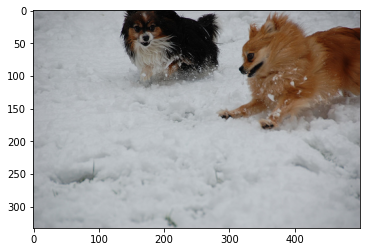

Greedy: a small dog is running through the snow


In [27]:
pic = '2398605966_1d0c9e6a20.jpg'
image = encoding_test[pic].reshape((1,2048))
x = plt.imread(images_path + "/" + pic)
plt.imshow(x)
plt.show()

print("Greedy:",greedySearch(image))

## Saving Texts

In [32]:
out_text_dict = {}
i = 0
for img in encoding_train.keys():
    i += 1
    features = encoding_train[img].reshape((1, 2048))
    text = greedySearch(features)
    out_text_dict[img] = text
    print("Caption succesfully generated for training image", i, "!\n")
i = 0
for img in encoding_test.keys():
    features = encoding_test[img].reshape((1, 2048))
    text = greedySearch(features)
    out_text_dict[img] = text
    print("Caption succesfully generated for testing image", i, "!\n")

Caption succesfully generated for training image 1 !

Caption succesfully generated for training image 2 !

Caption succesfully generated for training image 3 !

Caption succesfully generated for training image 4 !

Caption succesfully generated for training image 5 !

Caption succesfully generated for training image 6 !

Caption succesfully generated for training image 7 !

Caption succesfully generated for training image 8 !

Caption succesfully generated for training image 9 !

Caption succesfully generated for training image 10 !

Caption succesfully generated for training image 11 !

Caption succesfully generated for training image 12 !

Caption succesfully generated for training image 13 !

Caption succesfully generated for training image 14 !

Caption succesfully generated for training image 15 !

Caption succesfully generated for training image 16 !

Caption succesfully generated for training image 17 !

Caption succesfully generated for training image 18 !

Caption succesfully

Caption succesfully generated for training image 150 !

Caption succesfully generated for training image 151 !

Caption succesfully generated for training image 152 !

Caption succesfully generated for training image 153 !

Caption succesfully generated for training image 154 !

Caption succesfully generated for training image 155 !

Caption succesfully generated for training image 156 !

Caption succesfully generated for training image 157 !

Caption succesfully generated for training image 158 !

Caption succesfully generated for training image 159 !

Caption succesfully generated for training image 160 !

Caption succesfully generated for training image 161 !

Caption succesfully generated for training image 162 !

Caption succesfully generated for training image 163 !

Caption succesfully generated for training image 164 !

Caption succesfully generated for training image 165 !

Caption succesfully generated for training image 166 !

Caption succesfully generated for training image

Caption succesfully generated for training image 297 !

Caption succesfully generated for training image 298 !

Caption succesfully generated for training image 299 !

Caption succesfully generated for training image 300 !

Caption succesfully generated for training image 301 !

Caption succesfully generated for training image 302 !

Caption succesfully generated for training image 303 !

Caption succesfully generated for training image 304 !

Caption succesfully generated for training image 305 !

Caption succesfully generated for training image 306 !

Caption succesfully generated for training image 307 !

Caption succesfully generated for training image 308 !

Caption succesfully generated for training image 309 !

Caption succesfully generated for training image 310 !

Caption succesfully generated for training image 311 !

Caption succesfully generated for training image 312 !

Caption succesfully generated for training image 313 !

Caption succesfully generated for training image

Caption succesfully generated for training image 444 !

Caption succesfully generated for training image 445 !

Caption succesfully generated for training image 446 !

Caption succesfully generated for training image 447 !

Caption succesfully generated for training image 448 !

Caption succesfully generated for training image 449 !

Caption succesfully generated for training image 450 !

Caption succesfully generated for training image 451 !

Caption succesfully generated for training image 452 !

Caption succesfully generated for training image 453 !

Caption succesfully generated for training image 454 !

Caption succesfully generated for training image 455 !

Caption succesfully generated for training image 456 !

Caption succesfully generated for training image 457 !

Caption succesfully generated for training image 458 !

Caption succesfully generated for training image 459 !

Caption succesfully generated for training image 460 !

Caption succesfully generated for training image

Caption succesfully generated for training image 591 !

Caption succesfully generated for training image 592 !

Caption succesfully generated for training image 593 !

Caption succesfully generated for training image 594 !

Caption succesfully generated for training image 595 !

Caption succesfully generated for training image 596 !

Caption succesfully generated for training image 597 !

Caption succesfully generated for training image 598 !

Caption succesfully generated for training image 599 !

Caption succesfully generated for training image 600 !

Caption succesfully generated for training image 601 !

Caption succesfully generated for training image 602 !

Caption succesfully generated for training image 603 !

Caption succesfully generated for training image 604 !

Caption succesfully generated for training image 605 !

Caption succesfully generated for training image 606 !

Caption succesfully generated for training image 607 !

Caption succesfully generated for training image

Caption succesfully generated for training image 738 !

Caption succesfully generated for training image 739 !

Caption succesfully generated for training image 740 !

Caption succesfully generated for training image 741 !

Caption succesfully generated for training image 742 !

Caption succesfully generated for training image 743 !

Caption succesfully generated for training image 744 !

Caption succesfully generated for training image 745 !

Caption succesfully generated for training image 746 !

Caption succesfully generated for training image 747 !

Caption succesfully generated for training image 748 !

Caption succesfully generated for training image 749 !

Caption succesfully generated for training image 750 !

Caption succesfully generated for training image 751 !

Caption succesfully generated for training image 752 !

Caption succesfully generated for training image 753 !

Caption succesfully generated for training image 754 !

Caption succesfully generated for training image

Caption succesfully generated for training image 885 !

Caption succesfully generated for training image 886 !

Caption succesfully generated for training image 887 !

Caption succesfully generated for training image 888 !

Caption succesfully generated for training image 889 !

Caption succesfully generated for training image 890 !

Caption succesfully generated for training image 891 !

Caption succesfully generated for training image 892 !

Caption succesfully generated for training image 893 !

Caption succesfully generated for training image 894 !

Caption succesfully generated for training image 895 !

Caption succesfully generated for training image 896 !

Caption succesfully generated for training image 897 !

Caption succesfully generated for training image 898 !

Caption succesfully generated for training image 899 !

Caption succesfully generated for training image 900 !

Caption succesfully generated for training image 901 !

Caption succesfully generated for training image

Caption succesfully generated for training image 1031 !

Caption succesfully generated for training image 1032 !

Caption succesfully generated for training image 1033 !

Caption succesfully generated for training image 1034 !

Caption succesfully generated for training image 1035 !

Caption succesfully generated for training image 1036 !

Caption succesfully generated for training image 1037 !

Caption succesfully generated for training image 1038 !

Caption succesfully generated for training image 1039 !

Caption succesfully generated for training image 1040 !

Caption succesfully generated for training image 1041 !

Caption succesfully generated for training image 1042 !

Caption succesfully generated for training image 1043 !

Caption succesfully generated for training image 1044 !

Caption succesfully generated for training image 1045 !

Caption succesfully generated for training image 1046 !

Caption succesfully generated for training image 1047 !

Caption succesfully generated f

Caption succesfully generated for training image 1175 !

Caption succesfully generated for training image 1176 !

Caption succesfully generated for training image 1177 !

Caption succesfully generated for training image 1178 !

Caption succesfully generated for training image 1179 !

Caption succesfully generated for training image 1180 !

Caption succesfully generated for training image 1181 !

Caption succesfully generated for training image 1182 !

Caption succesfully generated for training image 1183 !

Caption succesfully generated for training image 1184 !

Caption succesfully generated for training image 1185 !

Caption succesfully generated for training image 1186 !

Caption succesfully generated for training image 1187 !

Caption succesfully generated for training image 1188 !

Caption succesfully generated for training image 1189 !

Caption succesfully generated for training image 1190 !

Caption succesfully generated for training image 1191 !

Caption succesfully generated f

Caption succesfully generated for training image 1319 !

Caption succesfully generated for training image 1320 !

Caption succesfully generated for training image 1321 !

Caption succesfully generated for training image 1322 !

Caption succesfully generated for training image 1323 !

Caption succesfully generated for training image 1324 !

Caption succesfully generated for training image 1325 !

Caption succesfully generated for training image 1326 !

Caption succesfully generated for training image 1327 !

Caption succesfully generated for training image 1328 !

Caption succesfully generated for training image 1329 !

Caption succesfully generated for training image 1330 !

Caption succesfully generated for training image 1331 !

Caption succesfully generated for training image 1332 !

Caption succesfully generated for training image 1333 !

Caption succesfully generated for training image 1334 !

Caption succesfully generated for training image 1335 !

Caption succesfully generated f

Caption succesfully generated for training image 1463 !

Caption succesfully generated for training image 1464 !

Caption succesfully generated for training image 1465 !

Caption succesfully generated for training image 1466 !

Caption succesfully generated for training image 1467 !

Caption succesfully generated for training image 1468 !

Caption succesfully generated for training image 1469 !

Caption succesfully generated for training image 1470 !

Caption succesfully generated for training image 1471 !

Caption succesfully generated for training image 1472 !

Caption succesfully generated for training image 1473 !

Caption succesfully generated for training image 1474 !

Caption succesfully generated for training image 1475 !

Caption succesfully generated for training image 1476 !

Caption succesfully generated for training image 1477 !

Caption succesfully generated for training image 1478 !

Caption succesfully generated for training image 1479 !

Caption succesfully generated f

Caption succesfully generated for training image 1607 !

Caption succesfully generated for training image 1608 !

Caption succesfully generated for training image 1609 !

Caption succesfully generated for training image 1610 !

Caption succesfully generated for training image 1611 !

Caption succesfully generated for training image 1612 !

Caption succesfully generated for training image 1613 !

Caption succesfully generated for training image 1614 !

Caption succesfully generated for training image 1615 !

Caption succesfully generated for training image 1616 !

Caption succesfully generated for training image 1617 !

Caption succesfully generated for training image 1618 !

Caption succesfully generated for training image 1619 !

Caption succesfully generated for training image 1620 !

Caption succesfully generated for training image 1621 !

Caption succesfully generated for training image 1622 !

Caption succesfully generated for training image 1623 !

Caption succesfully generated f

Caption succesfully generated for training image 1751 !

Caption succesfully generated for training image 1752 !

Caption succesfully generated for training image 1753 !

Caption succesfully generated for training image 1754 !

Caption succesfully generated for training image 1755 !

Caption succesfully generated for training image 1756 !

Caption succesfully generated for training image 1757 !

Caption succesfully generated for training image 1758 !

Caption succesfully generated for training image 1759 !

Caption succesfully generated for training image 1760 !

Caption succesfully generated for training image 1761 !

Caption succesfully generated for training image 1762 !

Caption succesfully generated for training image 1763 !

Caption succesfully generated for training image 1764 !

Caption succesfully generated for training image 1765 !

Caption succesfully generated for training image 1766 !

Caption succesfully generated for training image 1767 !

Caption succesfully generated f

Caption succesfully generated for training image 1895 !

Caption succesfully generated for training image 1896 !

Caption succesfully generated for training image 1897 !

Caption succesfully generated for training image 1898 !

Caption succesfully generated for training image 1899 !

Caption succesfully generated for training image 1900 !

Caption succesfully generated for training image 1901 !

Caption succesfully generated for training image 1902 !

Caption succesfully generated for training image 1903 !

Caption succesfully generated for training image 1904 !

Caption succesfully generated for training image 1905 !

Caption succesfully generated for training image 1906 !

Caption succesfully generated for training image 1907 !

Caption succesfully generated for training image 1908 !

Caption succesfully generated for training image 1909 !

Caption succesfully generated for training image 1910 !

Caption succesfully generated for training image 1911 !

Caption succesfully generated f

Caption succesfully generated for training image 2039 !

Caption succesfully generated for training image 2040 !

Caption succesfully generated for training image 2041 !

Caption succesfully generated for training image 2042 !

Caption succesfully generated for training image 2043 !

Caption succesfully generated for training image 2044 !

Caption succesfully generated for training image 2045 !

Caption succesfully generated for training image 2046 !

Caption succesfully generated for training image 2047 !

Caption succesfully generated for training image 2048 !

Caption succesfully generated for training image 2049 !

Caption succesfully generated for training image 2050 !

Caption succesfully generated for training image 2051 !

Caption succesfully generated for training image 2052 !

Caption succesfully generated for training image 2053 !

Caption succesfully generated for training image 2054 !

Caption succesfully generated for training image 2055 !

Caption succesfully generated f

Caption succesfully generated for training image 2183 !

Caption succesfully generated for training image 2184 !

Caption succesfully generated for training image 2185 !

Caption succesfully generated for training image 2186 !

Caption succesfully generated for training image 2187 !

Caption succesfully generated for training image 2188 !

Caption succesfully generated for training image 2189 !

Caption succesfully generated for training image 2190 !

Caption succesfully generated for training image 2191 !

Caption succesfully generated for training image 2192 !

Caption succesfully generated for training image 2193 !

Caption succesfully generated for training image 2194 !

Caption succesfully generated for training image 2195 !

Caption succesfully generated for training image 2196 !

Caption succesfully generated for training image 2197 !

Caption succesfully generated for training image 2198 !

Caption succesfully generated for training image 2199 !

Caption succesfully generated f

Caption succesfully generated for training image 2327 !

Caption succesfully generated for training image 2328 !

Caption succesfully generated for training image 2329 !

Caption succesfully generated for training image 2330 !

Caption succesfully generated for training image 2331 !

Caption succesfully generated for training image 2332 !

Caption succesfully generated for training image 2333 !

Caption succesfully generated for training image 2334 !

Caption succesfully generated for training image 2335 !

Caption succesfully generated for training image 2336 !

Caption succesfully generated for training image 2337 !

Caption succesfully generated for training image 2338 !

Caption succesfully generated for training image 2339 !

Caption succesfully generated for training image 2340 !

Caption succesfully generated for training image 2341 !

Caption succesfully generated for training image 2342 !

Caption succesfully generated for training image 2343 !

Caption succesfully generated f

Caption succesfully generated for training image 2471 !

Caption succesfully generated for training image 2472 !

Caption succesfully generated for training image 2473 !

Caption succesfully generated for training image 2474 !

Caption succesfully generated for training image 2475 !

Caption succesfully generated for training image 2476 !

Caption succesfully generated for training image 2477 !

Caption succesfully generated for training image 2478 !

Caption succesfully generated for training image 2479 !

Caption succesfully generated for training image 2480 !

Caption succesfully generated for training image 2481 !

Caption succesfully generated for training image 2482 !

Caption succesfully generated for training image 2483 !

Caption succesfully generated for training image 2484 !

Caption succesfully generated for training image 2485 !

Caption succesfully generated for training image 2486 !

Caption succesfully generated for training image 2487 !

Caption succesfully generated f

Caption succesfully generated for training image 2615 !

Caption succesfully generated for training image 2616 !

Caption succesfully generated for training image 2617 !

Caption succesfully generated for training image 2618 !

Caption succesfully generated for training image 2619 !

Caption succesfully generated for training image 2620 !

Caption succesfully generated for training image 2621 !

Caption succesfully generated for training image 2622 !

Caption succesfully generated for training image 2623 !

Caption succesfully generated for training image 2624 !

Caption succesfully generated for training image 2625 !

Caption succesfully generated for training image 2626 !

Caption succesfully generated for training image 2627 !

Caption succesfully generated for training image 2628 !

Caption succesfully generated for training image 2629 !

Caption succesfully generated for training image 2630 !

Caption succesfully generated for training image 2631 !

Caption succesfully generated f

Caption succesfully generated for training image 2759 !

Caption succesfully generated for training image 2760 !

Caption succesfully generated for training image 2761 !

Caption succesfully generated for training image 2762 !

Caption succesfully generated for training image 2763 !

Caption succesfully generated for training image 2764 !

Caption succesfully generated for training image 2765 !

Caption succesfully generated for training image 2766 !

Caption succesfully generated for training image 2767 !

Caption succesfully generated for training image 2768 !

Caption succesfully generated for training image 2769 !

Caption succesfully generated for training image 2770 !

Caption succesfully generated for training image 2771 !

Caption succesfully generated for training image 2772 !

Caption succesfully generated for training image 2773 !

Caption succesfully generated for training image 2774 !

Caption succesfully generated for training image 2775 !

Caption succesfully generated f

Caption succesfully generated for training image 2903 !

Caption succesfully generated for training image 2904 !

Caption succesfully generated for training image 2905 !

Caption succesfully generated for training image 2906 !

Caption succesfully generated for training image 2907 !

Caption succesfully generated for training image 2908 !

Caption succesfully generated for training image 2909 !

Caption succesfully generated for training image 2910 !

Caption succesfully generated for training image 2911 !

Caption succesfully generated for training image 2912 !

Caption succesfully generated for training image 2913 !

Caption succesfully generated for training image 2914 !

Caption succesfully generated for training image 2915 !

Caption succesfully generated for training image 2916 !

Caption succesfully generated for training image 2917 !

Caption succesfully generated for training image 2918 !

Caption succesfully generated for training image 2919 !

Caption succesfully generated f

Caption succesfully generated for training image 3047 !

Caption succesfully generated for training image 3048 !

Caption succesfully generated for training image 3049 !

Caption succesfully generated for training image 3050 !

Caption succesfully generated for training image 3051 !

Caption succesfully generated for training image 3052 !

Caption succesfully generated for training image 3053 !

Caption succesfully generated for training image 3054 !

Caption succesfully generated for training image 3055 !

Caption succesfully generated for training image 3056 !

Caption succesfully generated for training image 3057 !

Caption succesfully generated for training image 3058 !

Caption succesfully generated for training image 3059 !

Caption succesfully generated for training image 3060 !

Caption succesfully generated for training image 3061 !

Caption succesfully generated for training image 3062 !

Caption succesfully generated for training image 3063 !

Caption succesfully generated f

Caption succesfully generated for training image 3191 !

Caption succesfully generated for training image 3192 !

Caption succesfully generated for training image 3193 !

Caption succesfully generated for training image 3194 !

Caption succesfully generated for training image 3195 !

Caption succesfully generated for training image 3196 !

Caption succesfully generated for training image 3197 !

Caption succesfully generated for training image 3198 !

Caption succesfully generated for training image 3199 !

Caption succesfully generated for training image 3200 !

Caption succesfully generated for training image 3201 !

Caption succesfully generated for training image 3202 !

Caption succesfully generated for training image 3203 !

Caption succesfully generated for training image 3204 !

Caption succesfully generated for training image 3205 !

Caption succesfully generated for training image 3206 !

Caption succesfully generated for training image 3207 !

Caption succesfully generated f

Caption succesfully generated for training image 3335 !

Caption succesfully generated for training image 3336 !

Caption succesfully generated for training image 3337 !

Caption succesfully generated for training image 3338 !

Caption succesfully generated for training image 3339 !

Caption succesfully generated for training image 3340 !

Caption succesfully generated for training image 3341 !

Caption succesfully generated for training image 3342 !

Caption succesfully generated for training image 3343 !

Caption succesfully generated for training image 3344 !

Caption succesfully generated for training image 3345 !

Caption succesfully generated for training image 3346 !

Caption succesfully generated for training image 3347 !

Caption succesfully generated for training image 3348 !

Caption succesfully generated for training image 3349 !

Caption succesfully generated for training image 3350 !

Caption succesfully generated for training image 3351 !

Caption succesfully generated f

Caption succesfully generated for training image 3479 !

Caption succesfully generated for training image 3480 !

Caption succesfully generated for training image 3481 !

Caption succesfully generated for training image 3482 !

Caption succesfully generated for training image 3483 !

Caption succesfully generated for training image 3484 !

Caption succesfully generated for training image 3485 !

Caption succesfully generated for training image 3486 !

Caption succesfully generated for training image 3487 !

Caption succesfully generated for training image 3488 !

Caption succesfully generated for training image 3489 !

Caption succesfully generated for training image 3490 !

Caption succesfully generated for training image 3491 !

Caption succesfully generated for training image 3492 !

Caption succesfully generated for training image 3493 !

Caption succesfully generated for training image 3494 !

Caption succesfully generated for training image 3495 !

Caption succesfully generated f

Caption succesfully generated for training image 3623 !

Caption succesfully generated for training image 3624 !

Caption succesfully generated for training image 3625 !

Caption succesfully generated for training image 3626 !

Caption succesfully generated for training image 3627 !

Caption succesfully generated for training image 3628 !

Caption succesfully generated for training image 3629 !

Caption succesfully generated for training image 3630 !

Caption succesfully generated for training image 3631 !

Caption succesfully generated for training image 3632 !

Caption succesfully generated for training image 3633 !

Caption succesfully generated for training image 3634 !

Caption succesfully generated for training image 3635 !

Caption succesfully generated for training image 3636 !

Caption succesfully generated for training image 3637 !

Caption succesfully generated for training image 3638 !

Caption succesfully generated for training image 3639 !

Caption succesfully generated f

Caption succesfully generated for training image 3767 !

Caption succesfully generated for training image 3768 !

Caption succesfully generated for training image 3769 !

Caption succesfully generated for training image 3770 !

Caption succesfully generated for training image 3771 !

Caption succesfully generated for training image 3772 !

Caption succesfully generated for training image 3773 !

Caption succesfully generated for training image 3774 !

Caption succesfully generated for training image 3775 !

Caption succesfully generated for training image 3776 !

Caption succesfully generated for training image 3777 !

Caption succesfully generated for training image 3778 !

Caption succesfully generated for training image 3779 !

Caption succesfully generated for training image 3780 !

Caption succesfully generated for training image 3781 !

Caption succesfully generated for training image 3782 !

Caption succesfully generated for training image 3783 !

Caption succesfully generated f

Caption succesfully generated for training image 3911 !

Caption succesfully generated for training image 3912 !

Caption succesfully generated for training image 3913 !

Caption succesfully generated for training image 3914 !

Caption succesfully generated for training image 3915 !

Caption succesfully generated for training image 3916 !

Caption succesfully generated for training image 3917 !

Caption succesfully generated for training image 3918 !

Caption succesfully generated for training image 3919 !

Caption succesfully generated for training image 3920 !

Caption succesfully generated for training image 3921 !

Caption succesfully generated for training image 3922 !

Caption succesfully generated for training image 3923 !

Caption succesfully generated for training image 3924 !

Caption succesfully generated for training image 3925 !

Caption succesfully generated for training image 3926 !

Caption succesfully generated for training image 3927 !

Caption succesfully generated f

Caption succesfully generated for training image 4055 !

Caption succesfully generated for training image 4056 !

Caption succesfully generated for training image 4057 !

Caption succesfully generated for training image 4058 !

Caption succesfully generated for training image 4059 !

Caption succesfully generated for training image 4060 !

Caption succesfully generated for training image 4061 !

Caption succesfully generated for training image 4062 !

Caption succesfully generated for training image 4063 !

Caption succesfully generated for training image 4064 !

Caption succesfully generated for training image 4065 !

Caption succesfully generated for training image 4066 !

Caption succesfully generated for training image 4067 !

Caption succesfully generated for training image 4068 !

Caption succesfully generated for training image 4069 !

Caption succesfully generated for training image 4070 !

Caption succesfully generated for training image 4071 !

Caption succesfully generated f

Caption succesfully generated for training image 4199 !

Caption succesfully generated for training image 4200 !

Caption succesfully generated for training image 4201 !

Caption succesfully generated for training image 4202 !

Caption succesfully generated for training image 4203 !

Caption succesfully generated for training image 4204 !

Caption succesfully generated for training image 4205 !

Caption succesfully generated for training image 4206 !

Caption succesfully generated for training image 4207 !

Caption succesfully generated for training image 4208 !

Caption succesfully generated for training image 4209 !

Caption succesfully generated for training image 4210 !

Caption succesfully generated for training image 4211 !

Caption succesfully generated for training image 4212 !

Caption succesfully generated for training image 4213 !

Caption succesfully generated for training image 4214 !

Caption succesfully generated for training image 4215 !

Caption succesfully generated f

Caption succesfully generated for training image 4343 !

Caption succesfully generated for training image 4344 !

Caption succesfully generated for training image 4345 !

Caption succesfully generated for training image 4346 !

Caption succesfully generated for training image 4347 !

Caption succesfully generated for training image 4348 !

Caption succesfully generated for training image 4349 !

Caption succesfully generated for training image 4350 !

Caption succesfully generated for training image 4351 !

Caption succesfully generated for training image 4352 !

Caption succesfully generated for training image 4353 !

Caption succesfully generated for training image 4354 !

Caption succesfully generated for training image 4355 !

Caption succesfully generated for training image 4356 !

Caption succesfully generated for training image 4357 !

Caption succesfully generated for training image 4358 !

Caption succesfully generated for training image 4359 !

Caption succesfully generated f

Caption succesfully generated for training image 4487 !

Caption succesfully generated for training image 4488 !

Caption succesfully generated for training image 4489 !

Caption succesfully generated for training image 4490 !

Caption succesfully generated for training image 4491 !

Caption succesfully generated for training image 4492 !

Caption succesfully generated for training image 4493 !

Caption succesfully generated for training image 4494 !

Caption succesfully generated for training image 4495 !

Caption succesfully generated for training image 4496 !

Caption succesfully generated for training image 4497 !

Caption succesfully generated for training image 4498 !

Caption succesfully generated for training image 4499 !

Caption succesfully generated for training image 4500 !

Caption succesfully generated for training image 4501 !

Caption succesfully generated for training image 4502 !

Caption succesfully generated for training image 4503 !

Caption succesfully generated f

Caption succesfully generated for training image 4631 !

Caption succesfully generated for training image 4632 !

Caption succesfully generated for training image 4633 !

Caption succesfully generated for training image 4634 !

Caption succesfully generated for training image 4635 !

Caption succesfully generated for training image 4636 !

Caption succesfully generated for training image 4637 !

Caption succesfully generated for training image 4638 !

Caption succesfully generated for training image 4639 !

Caption succesfully generated for training image 4640 !

Caption succesfully generated for training image 4641 !

Caption succesfully generated for training image 4642 !

Caption succesfully generated for training image 4643 !

Caption succesfully generated for training image 4644 !

Caption succesfully generated for training image 4645 !

Caption succesfully generated for training image 4646 !

Caption succesfully generated for training image 4647 !

Caption succesfully generated f

Caption succesfully generated for training image 4775 !

Caption succesfully generated for training image 4776 !

Caption succesfully generated for training image 4777 !

Caption succesfully generated for training image 4778 !

Caption succesfully generated for training image 4779 !

Caption succesfully generated for training image 4780 !

Caption succesfully generated for training image 4781 !

Caption succesfully generated for training image 4782 !

Caption succesfully generated for training image 4783 !

Caption succesfully generated for training image 4784 !

Caption succesfully generated for training image 4785 !

Caption succesfully generated for training image 4786 !

Caption succesfully generated for training image 4787 !

Caption succesfully generated for training image 4788 !

Caption succesfully generated for training image 4789 !

Caption succesfully generated for training image 4790 !

Caption succesfully generated for training image 4791 !

Caption succesfully generated f

Caption succesfully generated for training image 4919 !

Caption succesfully generated for training image 4920 !

Caption succesfully generated for training image 4921 !

Caption succesfully generated for training image 4922 !

Caption succesfully generated for training image 4923 !

Caption succesfully generated for training image 4924 !

Caption succesfully generated for training image 4925 !

Caption succesfully generated for training image 4926 !

Caption succesfully generated for training image 4927 !

Caption succesfully generated for training image 4928 !

Caption succesfully generated for training image 4929 !

Caption succesfully generated for training image 4930 !

Caption succesfully generated for training image 4931 !

Caption succesfully generated for training image 4932 !

Caption succesfully generated for training image 4933 !

Caption succesfully generated for training image 4934 !

Caption succesfully generated for training image 4935 !

Caption succesfully generated f

Caption succesfully generated for training image 5063 !

Caption succesfully generated for training image 5064 !

Caption succesfully generated for training image 5065 !

Caption succesfully generated for training image 5066 !

Caption succesfully generated for training image 5067 !

Caption succesfully generated for training image 5068 !

Caption succesfully generated for training image 5069 !

Caption succesfully generated for training image 5070 !

Caption succesfully generated for training image 5071 !

Caption succesfully generated for training image 5072 !

Caption succesfully generated for training image 5073 !

Caption succesfully generated for training image 5074 !

Caption succesfully generated for training image 5075 !

Caption succesfully generated for training image 5076 !

Caption succesfully generated for training image 5077 !

Caption succesfully generated for training image 5078 !

Caption succesfully generated for training image 5079 !

Caption succesfully generated f

Caption succesfully generated for training image 5207 !

Caption succesfully generated for training image 5208 !

Caption succesfully generated for training image 5209 !

Caption succesfully generated for training image 5210 !

Caption succesfully generated for training image 5211 !

Caption succesfully generated for training image 5212 !

Caption succesfully generated for training image 5213 !

Caption succesfully generated for training image 5214 !

Caption succesfully generated for training image 5215 !

Caption succesfully generated for training image 5216 !

Caption succesfully generated for training image 5217 !

Caption succesfully generated for training image 5218 !

Caption succesfully generated for training image 5219 !

Caption succesfully generated for training image 5220 !

Caption succesfully generated for training image 5221 !

Caption succesfully generated for training image 5222 !

Caption succesfully generated for training image 5223 !

Caption succesfully generated f

Caption succesfully generated for training image 5351 !

Caption succesfully generated for training image 5352 !

Caption succesfully generated for training image 5353 !

Caption succesfully generated for training image 5354 !

Caption succesfully generated for training image 5355 !

Caption succesfully generated for training image 5356 !

Caption succesfully generated for training image 5357 !

Caption succesfully generated for training image 5358 !

Caption succesfully generated for training image 5359 !

Caption succesfully generated for training image 5360 !

Caption succesfully generated for training image 5361 !

Caption succesfully generated for training image 5362 !

Caption succesfully generated for training image 5363 !

Caption succesfully generated for training image 5364 !

Caption succesfully generated for training image 5365 !

Caption succesfully generated for training image 5366 !

Caption succesfully generated for training image 5367 !

Caption succesfully generated f

Caption succesfully generated for training image 5495 !

Caption succesfully generated for training image 5496 !

Caption succesfully generated for training image 5497 !

Caption succesfully generated for training image 5498 !

Caption succesfully generated for training image 5499 !

Caption succesfully generated for training image 5500 !

Caption succesfully generated for training image 5501 !

Caption succesfully generated for training image 5502 !

Caption succesfully generated for training image 5503 !

Caption succesfully generated for training image 5504 !

Caption succesfully generated for training image 5505 !

Caption succesfully generated for training image 5506 !

Caption succesfully generated for training image 5507 !

Caption succesfully generated for training image 5508 !

Caption succesfully generated for training image 5509 !

Caption succesfully generated for training image 5510 !

Caption succesfully generated for training image 5511 !

Caption succesfully generated f

Caption succesfully generated for training image 5639 !

Caption succesfully generated for training image 5640 !

Caption succesfully generated for training image 5641 !

Caption succesfully generated for training image 5642 !

Caption succesfully generated for training image 5643 !

Caption succesfully generated for training image 5644 !

Caption succesfully generated for training image 5645 !

Caption succesfully generated for training image 5646 !

Caption succesfully generated for training image 5647 !

Caption succesfully generated for training image 5648 !

Caption succesfully generated for training image 5649 !

Caption succesfully generated for training image 5650 !

Caption succesfully generated for training image 5651 !

Caption succesfully generated for training image 5652 !

Caption succesfully generated for training image 5653 !

Caption succesfully generated for training image 5654 !

Caption succesfully generated for training image 5655 !

Caption succesfully generated f

Caption succesfully generated for training image 5783 !

Caption succesfully generated for training image 5784 !

Caption succesfully generated for training image 5785 !

Caption succesfully generated for training image 5786 !

Caption succesfully generated for training image 5787 !

Caption succesfully generated for training image 5788 !

Caption succesfully generated for training image 5789 !

Caption succesfully generated for training image 5790 !

Caption succesfully generated for training image 5791 !

Caption succesfully generated for training image 5792 !

Caption succesfully generated for training image 5793 !

Caption succesfully generated for training image 5794 !

Caption succesfully generated for training image 5795 !

Caption succesfully generated for training image 5796 !

Caption succesfully generated for training image 5797 !

Caption succesfully generated for training image 5798 !

Caption succesfully generated for training image 5799 !

Caption succesfully generated f

Caption succesfully generated for training image 5927 !

Caption succesfully generated for training image 5928 !

Caption succesfully generated for training image 5929 !

Caption succesfully generated for training image 5930 !

Caption succesfully generated for training image 5931 !

Caption succesfully generated for training image 5932 !

Caption succesfully generated for training image 5933 !

Caption succesfully generated for training image 5934 !

Caption succesfully generated for training image 5935 !

Caption succesfully generated for training image 5936 !

Caption succesfully generated for training image 5937 !

Caption succesfully generated for training image 5938 !

Caption succesfully generated for training image 5939 !

Caption succesfully generated for training image 5940 !

Caption succesfully generated for training image 5941 !

Caption succesfully generated for training image 5942 !

Caption succesfully generated for training image 5943 !

Caption succesfully generated f

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing imag

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing imag

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing imag

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing imag

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing imag

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing image 0 !

Caption succesfully generated for testing imag

In [34]:
import json
with open("caption_out.json", "w") as file:
    json.dump(out_text_dict, file)